# Web Scraping
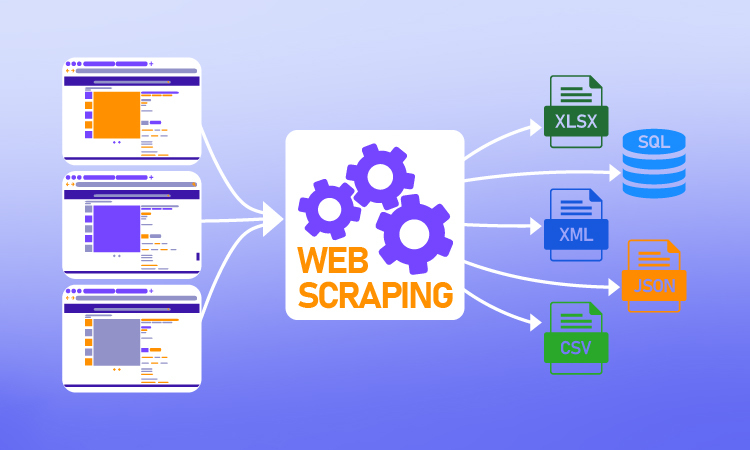
Image source: https://www.crawlnow.com/blog/what-is-web-scraping

#### Lab adapted from https://colab.research.google.com/github/dlsun/pods/blob/master/11-Hierarchical-Data/11.3%20Web%20Scraping.ipynb#scrollTo=hMmOJP-ZuWvj

**HTML**, which stands for "hypertext markup language", is an XML-like language for specifying the appearance of web pages. Each tag in HTML corresponds to a specific page element. For example:

- `<img>` specifies an image. The path to the image file is specified in the `src=` attribute.
- `<a>` specifies a hyperlink. The text enclosed between `<a>` and `</a>` is the text of the link that appears, while the URL is specified in the `href=` attribute of the tag.
- `<table>` specifies a table. The rows of the table are specified by `<tr>` tags nested inside the `<table>` tag, while the cells in each row are specified by `<td>` tags nested inside each `<tr>` tag.

# Inspecting HTML Source Code

Suppose we want to scrape faculty information from the [Cal Poly Statistics Department directory](https://statistics.calpoly.edu/content/directory) (`https://statistics.calpoly.edu/content/directory`). Once we have identified a web page that we want to scrape, the next step is to study the HTML source code. All web browsers have a feature that will display the HTML source of a web page.

Visit the web page above, and view the HTML source of that page (Right click, then choose "View Page Source"). Scroll down until you find the HTML code for the table containing information about the name, office, phone, e-mail, and office hours of the faculty members.

Notice how difficult it can be to find a page element in the HTML source. Many browsers allow you to right-click on a page element and jump to the part of the HTML source corresponding to that element. Alternatively, you could pick a string in the desired table and do a Control-F to find that string in the HTML source.

# Web Scraping Using BeautifulSoup

`BeautifulSoup` is a Python library that makes it easy to navigate an HTML document. We can query tags by name or attribute, and we can narrow our search to the ancestors and descendants of specific tags. Many web sites have malformed HTML. `BeautifulSoup` handles malformed HTML more gracefully than prior scraping packages and is thus the library of choice.

First, we will issue an HTTP request to the URL to get the HTML source code. A response code of 200 means it was successful in getting the source code. A full list of codes is here: https://en.wikipedia.org/wiki/List_of_HTTP_status_codes

In [1]:
import requests
response = requests.get("https://statistics.calpoly.edu/content/directory")
response

<Response [200]>

The HTML source is stored in the `.content` attribute of the response object. We pass this HTML source into `BeautifulSoup` to obtain a tree-like representation of the HTML document.

In [2]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

Now we can search for tags within this HTML document, using tags like `.find_all()`. For example, we can find all tables on this page.

In [3]:
tables = soup.find_all("table")
len(tables)

3

It shows that there are 3 tables on the page. We are interested in the second one, which is index one.

In [4]:
table = tables[1]
table

<table cellspacing="0" class="directory backwhite" height="2667" summary="COSAM Dean's Office Staff" width="596"><tbody><tr><th scope="col" width="18%">
<p>Name</p>
</th>
<th scope="col" width="8%">Office</th>
<th scope="col" width="10%">Phone (805)</th>
<th scope="col" width="20%">Email</th>
<th scope="col" width="20%">
<p>Office HoURS </p>
</th>
</tr><tr><td><a href="/Kelly-Bodwin"><strong>Kelly Bodwin</strong></a></td>
<td><a href="https://maps.calpoly.edu/">25-106</a></td>
<td>756-2450</td>
<td><a href="mailto:kbodwin@calpoly.edu">kbodwin@calpoly.edu</a></td>
<td>
<p><b>MW </b>12:30-2pm</p>
<p><strong>F</strong> 1:10-2pm Zoom</p>
</td>
</tr><tr><td><a href="/Matt-Carlton"><strong>Matt Carlton</strong></a></td>
<td><a href="https://maps.calpoly.edu/">25-101</a></td>
<td>756-7076</td>
<td><a href="mailto:rmlau@calpoly.edu">mcarlton@calpoly.edu</a></td>
<td>
<p><strong>MW</strong> 5:10-6:30pm</p>
<p><strong>F</strong> 3:10-4pm Zoom</p>
</td>
</tr><tr><td>
<p><a href="/Beth-Chance"><st

There is one faculty member per row in the table, except for the first row, which is the header. We iterate over all rows except for the first, extracting information about each faculty to append to `rows`, which we will eventually turn into a `DataFrame`. As you read the code below, refer to the HTML source above, so that you understand what each line is doing. In particular, ask yourself the following questions:

- `cells[0]` represents a `<td>` tag. Why do we need to call `.find("strong")` within this tag to get the name of the faculty member?
- For the most part, `link` is a hyperlink whose text is the faculty's office number. But for some faculty, `link` is `None`. For which faculty is this the case and why?

In [41]:
rows = []
for faculty in table.find_all("tr")[1:]:
    # Get all the cells in the row.
    cells = faculty.find_all("td")

    # The information we need is the text between tags.
    name_tag = cells[0].find("strong") or cells[0]
    name = name_tag.text

    link = cells[1].find("a")
    office = cells[1].text if link is None else link.text

    email_tag = cells[3].find("a") or cells[3]
    email = email_tag.text

    # Append this data.
    rows.append({
        "name": name,
        "office": office,
        "email": email
    })

In the code above, observe that `.find_all()` returns a list with all matching tags, while `.find()` returns only the first matching tag. If no matching tags are found, then `.find_all()` will return an empty list `[]`, while `.find()` will return `None`.

Finally, we turn `rows` into a `DataFrame`.

In [6]:
import pandas as pd
professor_info = pd.DataFrame(rows)
professor_info

,name,office,email
0,Kelly Bodwin,25-106,kbodwin@calpoly.edu
1,Matt Carlton,25-101,mcarlton@calpoly.edu
2,Beth Chance,25-235,bchance@calpoly.edu
3,Nian Cheng,Remote,ncheng@calpoly.edu
4,Olga Dekhtyar,25-225,odekhtya@calpoly.edu
5,Sinem Demirci,25-213,sdemirci@calpoly.edu
6,Jimmy Doi,25-108,jdoi@calpoly.edu
7,Samuel Frame,25-121,sframe@calpoly.edu
8,Frank Giron,25-207,frgiron@calpoly.edu
9,Hunter Glanz,25-111,hglanz@calpoly.edu


Now this data is ready for further processing.

## Ethical Quandary: `robots.txt`

Web robots are crawling the web all the time. A website may want to restrict the robots from crawling specific pages. One reason is financial: each visit to a web page, by a human or a robot, costs the website money, and the website may prefer to save their limited bandwidth for human visitors. Another reason is privacy: a website may not want a search engine to preserve a snapshot of a page for all eternity.

To specify what a web robot is and isn't allowed to crawl, most websites will place a text file named `robots.txt` in the top-level directory of the web server. For example, the Statistics department web page has a `robots.txt` file: https://statistics.calpoly.edu/robots.txt

The format of the `robots.txt` file should be self-explanatory, but you can read a full specification of the standard here: http://www.robotstxt.org/robotstxt.html. As you scrape websites using your web robot, always check the `robots.txt` file first, to make sure that you are respecting the wishes of the website owner.

# Exercises

### 1\. Modify the code above to also capture the phone number and office hours, then print out the updated dataframe below.

In [7]:
rows = []
for faculty in table.find_all("tr")[1:]:
    # Get all the cells in the row.
    cells = faculty.find_all("td")

    # The information we need is the text between tags.
    name_tag = cells[0].find("strong") or cells[0]
    name = name_tag.text

    link = cells[1].find("a")
    office = cells[1].text if link is None else link.text

    phone_tag = cells[2]
    phone_number = phone_tag.text

    email_tag = cells[3].find("a") or cells[3]
    email = email_tag.text

    hours_tag = cells[4]
    hours = cells[4].text if hours_tag is None else hours_tag.text

    # Append this data.
    rows.append({
        "name": name,
        "office": office,
        "phone": phone_number,
        "email": email,
        "hours": hours

    })
professor_info = pd.DataFrame(rows)
professor_info

,name,office,phone,email,hours
0,Kelly Bodwin,25-106,756-2450,kbodwin@calpoly.edu,\nMW 12:30-2pm\nF 1:10-2pm Zoom\n
1,Matt Carlton,25-101,756-7076,mcarlton@calpoly.edu,\nMW 5:10-6:30pm\nF 3:10-4pm Zoom\n
2,Beth Chance,25-235,\n756-2961\n,bchance@calpoly.edu,\nT 1:10-2pm\nW 11:10am-12pm\nR 1:10-2pm (in p...
3,Nian Cheng,Remote,756-2709,ncheng@calpoly.edu,MWR 1:10-2pm Zoom
4,Olga Dekhtyar,25-225,756-6354,odekhtya@calpoly.edu,\nTWRF 10:10-11am\n \n
5,Sinem Demirci,25-213,756-0683,sdemirci@calpoly.edu,"\nT 9:10-10am\nW 1:30-2:30pm\nR 9:10-10am,\n 1..."
6,Jimmy Doi,25-108,756-2901,jdoi@calpoly.edu,Sabbatical
7,Samuel Frame,25-121,756-5802,sframe@calpoly.edu,MTWR 1:30-2:30pm
8,Frank Giron,25-207,756-2759,frgiron@calpoly.edu,\nMTWR 11:10am-12pm \n
9,Hunter Glanz,25-111,756-2792,hglanz@calpoly.edu,\nM 10:10am-12pm \nT 8:10-9am\nW 10:10-11am\nA...


### 2\. Determine how many faculty members are on each floor of the 25 building using Python. The room number is provided by the last three digits of the "office" column. The floor is indicated by the first number of these three digits. For example, "25-110" means room 110 in building 25, which is on the first floor.

In [17]:
floors = {}
for x in professor_info.office:
    if x[:2] == '25':
        y = x[3]
        if y not in floors.keys():
            floors[y] = 1
        else: floors[y] += 1
print(floors)

{'1': 15, '2': 15}


###  Difficult optional challenge: Write code to ask the user for a given day and time, then use the updated dataframe from \#1 above to output which professors are available at that time. 

<Response [200]>

### 3. Find a website with a nicely structured table or tables that you can scrape. 

A few things to consider: The more simplistic the website format, the easier it will be to scrape. For example, https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Songs/500 would be easier than https://www.rollingstone.com/music/music-lists/best-songs-of-all-time-1224767/kanye-west-stronger-1224837/ to work with. You can decide how more of a challenge you want to make this. In general, Wikipedia has a lot of simply formatted tables.

Don't scrape any site that you're unsure about. For example, don't scrape a list of government employees or anything that could even be perceived as sensitive, even if it's publicly online. Stick with things like rankings of music, movies, countries, etc.

Lastly, make sure that the robots.txt file permits scraping. The site won't stop you, but do the right thing here.

In [51]:
response = requests.get("https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Songs/500")
response

<Response [200]>

### 4. Write code to scrape the site and do a light data analysis (light because I don't anticipate there being a ton of columns for us to analyze). 

Look at the HTML, identify what tags surround the text that you're looking for, and start writing code from there. Understand that no two scraping tasks will be exactly the same. HTML can be vastly different across different sites. This makes it difficult to give you any cookie cutter type of code here. It can be tricky but it shouldn't be much code. 

Once the scraping is working, do some data analysis on the data. For example, if using data for the top 500 songs of all time above, you could determine the top five most frequent artists on the list, or determine how many of the top 500 songs were written each decade.

If stuck, use StackOverflow, ChatGPT, or me as resources. You might even consider using an alternate web scraper such as Scrapy or Selenium (more powerful than BeautifulSoup, usually overkill).

In [52]:
soup = BeautifulSoup(response.content, "html.parser")
table = soup.find_all("table")
table = table[3]
table

<table class="wikitable sortable">
<caption>Full List: Rolling Stone's 500 Best Songs
</caption>
<tbody><tr>
<th>Rank
</th>
<th>Song
</th>
<th>Artist
</th>
<th>Year
</th></tr>
<tr>
<td>500
</td>
<td><a href="/wiki/Stronger_(Kanye_West_song)" title="Stronger (Kanye West song)">Stronger</a>
</td>
<td><a href="/wiki/Kanye_West" title="Kanye West">Kanye West</a>
</td>
<td>2007
</td></tr>
<tr>
<td>499
</td>
<td><a href="/wiki/Baby_Love" title="Baby Love">Baby Love</a>
</td>
<td><a href="/wiki/The_Supremes" title="The Supremes">The Supremes</a>
</td>
<td>1964
</td></tr>
<tr>
<td>498
</td>
<td><a href="/wiki/Pancho_and_Lefty" title="Pancho and Lefty">Pancho and Lefty</a>
</td>
<td><a href="/wiki/Townes_Van_Zandt" title="Townes Van Zandt">Townes Van Zandt</a>
</td>
<td>1972
</td></tr>
<tr>
<td>497
</td>
<td><a href="/wiki/Truth_Hurts_(song)" title="Truth Hurts (song)">Truth Hurts</a>
</td>
<td><a href="/wiki/Lizzo" title="Lizzo">Lizzo</a>
</td>
<td>2017
</td></tr>
<tr>
<td>496
</td>
<td><a hre

In [63]:

rows = []
for songs in table.find_all("tr")[1:]:
    # Get all the cells in the row.
    cells = songs.find_all("td")

    # The information we need is the text between tags.
    
    placing = cells[0].text[:-1]

    link = cells[1].find("a")
    song_name = cells[1].text if link is None else link.text

    name_tag = cells[2].find("a")
    name = name_tag.text

    release_year = cells[3].text[:-1]

    
    # Append this data.
    rows.append({
        "name": name,
        "song_name": song_name,
        "placing": placing,
        "release_year": release_year
    })
top500songs = pd.DataFrame(rows)
top500songs.head(20)
    

,name,song_name,placing,release_year
0,Kanye West,Stronger,500,2007
1,The Supremes,Baby Love,499,1964
2,Townes Van Zandt,Pancho and Lefty,498,1972
3,Lizzo,Truth Hurts,497,2017
4,Harry Nilsson,Without You,496,1971
5,Carly Simon,You're So Vain,495,1972
6,Cyndi Lauper,Time After Time,494,1983
7,Pixies,Where Is My Mind,493,1988
8,Miles Davis,So What,492,1959
9,Guns N' Roses,Welcome to the Jungle,491,1987
